## Imports

In [24]:
import tensorflow as tf
import seaborn as sns
import itertools
import matplotlib.pylab as plt

## GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

1

## Data loading

In [4]:
#directory of the dataset
DATA_DIR = 'NWPU-nature' 

#size of the image (images will be resized to these sizes)
img_height = 128
img_width = 128

#size of the batch
batch_size = 32

In [17]:
data = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7000 files belonging to 10 classes.


### Classes in the dataset

In [6]:
class_names = data.class_names
num_classes = len(class_names)
print(class_names)

['beach', 'chaparral', 'circular_farmland', 'desert', 'forest', 'island', 'lake', 'sea_ice', 'snowberg', 'terrace']


### Size of the train/val/test datasets

In [7]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [8]:
train = data.take(int(train_size))
val = data.skip(train_size).take(int(val_size))
test = data.skip(train_size+val_size).take(int(test_size))

print(f'Size of the training set: {len(train)*batch_size}')
print(f'Size of the validation set: {len(val)*batch_size}')
print(f'Size of the testing set: {len(test)*batch_size}')

Size of the training set: 4896
Size of the validation set: 1408
Size of the testing set: 704


### Balance of the dataset
Merging label batches to check balance of the dataset

In [12]:
to_flat = []
for batch in data.as_numpy_iterator():
    to_flat.append(batch[1])

flat_list = list(itertools.chain(*to_flat))
len(flat_list)

7000

### Plotting number of instances

<bound method Axes.plot of <Axes: title={'center': 'Numbers of classes'}, ylabel='count'>>

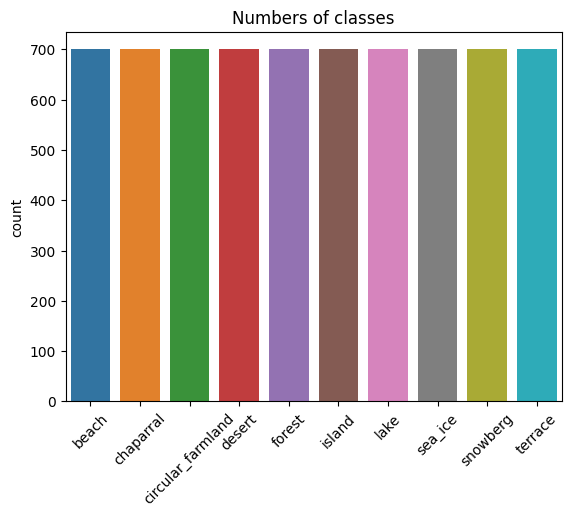

In [16]:
g = sns.countplot(x=flat_list)
g.set_xticklabels(class_names)
g.set_title('Numbers of classes')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.plot

### Shape of the images
should be: img_width (128) x img_height (128) x RGB pixels values (3)

In [19]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


### Saving the shape to the variable

In [21]:
shape = image_batch.shape[1:]
shape

TensorShape([128, 128, 3])

### Plotting sample images

In [22]:
image_batch,label_batch= next(iter(train))

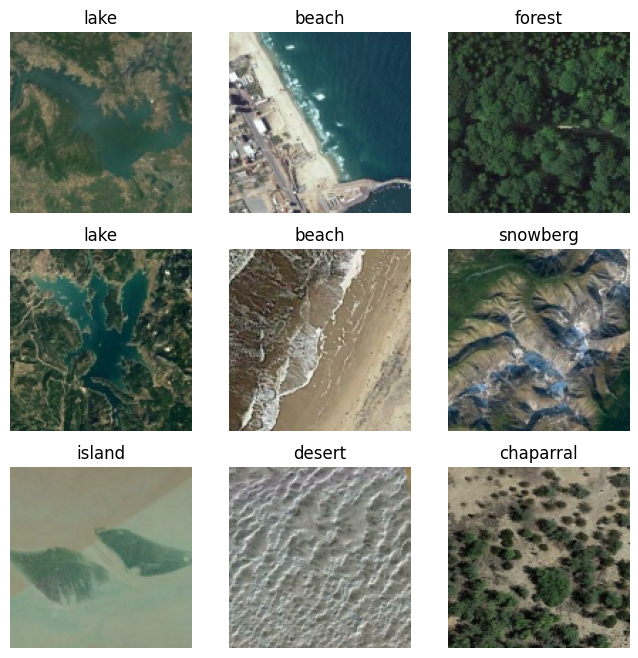

In [25]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = image_batch[i]/255
    fig.add_subplot(rows, columns, i)
    plt.title(class_names[int(label_batch[i])])
    plt.axis("off")
    plt.imshow(img)
plt.show()